In [ ]:
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from DAX.HelpFunctions.get_dax_data import get_dax_data
from datetime import timedelta
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
import pandas as pd
from DAX.Models.baseline import baseline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
# import importlib
# importlib.reload(Energy.Models)

In [ ]:
df = get_dax_data()

In [ ]:
# We have to start with the tuesday data
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [139]:
from HelpFunctions import mix_models
import importlib
importlib.reload(mix_models)

def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w+1} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        
        pred = None
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else: 
            pred = mix_models.mix_models(model['function'][0], model['function'][1], df_before, target='DAX')
        # Makes sure we try to find observations for dates that have an observation (e.g. 05-01 is missing)
        dates = [[horizon+1, d] for horizon,d in enumerate(pred['forecast_date']) if d in df.index]
        pred = pred.set_index('forecast_date')

        
        # Add observations to pred
        pred['observation'] = ''
        pred['score'] = ''
        for h,d in dates:
            # Look up the right observation for date d
            o = df.loc[d][f'ret{h}']
            pred.loc[d,'observation'] = o
    
        # Add scores to pred
        for index, row in pred.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['observation']
            
            score = evaluate_horizon(quantile_preds, observation)
            
            pred.at[index, 'score'] = score
            
        evaluation = pd.concat([evaluation, pred])
    evaluation = evaluation.sort_index()
    
    return evaluation

In [155]:
from DAX.Models import arma_garch_11 as ag
from DAX.Models import quant_reg as qr
from DAX.Models import baseline as bl
import importlib
importlib.reload(qr)
importlib.reload(bl)

models = [
    {
        'name': 'garch baseline',
        'function': [[ag.garch11_norm_1y, bl.baseline],[1.1]]
    },
    {
        'name': 'quant_reg baseline',
        'function': [[qr.quant_reg_3d, bl.baseline],[1.1]]
    },
    {
        'name': 'garch baseline quant_reg',
        'function': [[qr.quant_reg_3d, ag.garch11_norm_1y, bl.baseline],[1,1,1]]
    },
    {
        'name': 'baseline',
        'function': bl.baseline
    },
    # {
    #     'name': 'garch11_norm_2y',
    #     'function': ag.garch11_norm_2y
    # },
    # {
    #     'name': 'garch11_norm_5y',
    #     'function': ag.garch11_norm_5y
    # },
]


In [157]:
evaluate_models(models, df, 30, weeks=True)

*********** Start the evaluation of Model garch baseline ***********
Iteration 1 of 30
Iteration 2 of 30
Iteration 3 of 30
Iteration 4 of 30
Iteration 5 of 30
Iteration 6 of 30
Iteration 7 of 30
Iteration 8 of 30
Iteration 9 of 30
Iteration 10 of 30
Iteration 11 of 30
Iteration 12 of 30
Iteration 13 of 30
Iteration 14 of 30
Iteration 15 of 30
Iteration 16 of 30
Iteration 17 of 30
Iteration 18 of 30
Iteration 19 of 30
Iteration 20 of 30
Iteration 21 of 30
Iteration 22 of 30
Iteration 23 of 30
Iteration 24 of 30
Iteration 25 of 30
Iteration 26 of 30
Iteration 27 of 30
Iteration 28 of 30
Iteration 29 of 30
Iteration 30 of 30
*********** Start the evaluation of Model quant_reg baseline ***********
Iteration 1 of 30
Iteration 2 of 30
Iteration 3 of 30
Iteration 4 of 30
Iteration 5 of 30
Iteration 6 of 30
Iteration 7 of 30
Iteration 8 of 30
Iteration 9 of 30
Iteration 10 of 30
Iteration 11 of 30
Iteration 12 of 30
Iteration 13 of 30
Iteration 14 of 30
Iteration 15 of 30
Iteration 16 of 30
It

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Iteration 25 of 30
Iteration 26 of 30
Iteration 27 of 30
Iteration 28 of 30
Iteration 29 of 30
Iteration 30 of 30
*********** Start the evaluation of Model garch baseline quant_reg ***********
Iteration 1 of 30
Iteration 2 of 30
Iteration 3 of 30
Iteration 4 of 30
Iteration 5 of 30
Iteration 6 of 30
Iteration 7 of 30
Iteration 8 of 30
Iteration 9 of 30
Iteration 10 of 30
Iteration 11 of 30
Iteration 12 of 30
Iteration 13 of 30
Iteration 14 of 30
Iteration 15 of 30
Iteration 16 of 30
Iteration 17 of 30
Iteration 18 of 30
Iteration 19 of 30
Iteration 20 of 30
Iteration 21 of 30
Iteration 22 of 30
Iteration 23 of 30


/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Iteration 24 of 30
Iteration 25 of 30
Iteration 26 of 30
Iteration 27 of 30
Iteration 28 of 30
Iteration 29 of 30
Iteration 30 of 30
*********** Start the evaluation of Model baseline ***********
Iteration 1 of 30
Iteration 2 of 30
Iteration 3 of 30
Iteration 4 of 30
Iteration 5 of 30
Iteration 6 of 30
Iteration 7 of 30
Iteration 8 of 30
Iteration 9 of 30
Iteration 10 of 30
Iteration 11 of 30
Iteration 12 of 30
Iteration 13 of 30
Iteration 14 of 30
Iteration 15 of 30
Iteration 16 of 30
Iteration 17 of 30
Iteration 18 of 30
Iteration 19 of 30
Iteration 20 of 30
Iteration 21 of 30
Iteration 22 of 30
Iteration 23 of 30
Iteration 24 of 30
Iteration 25 of 30
Iteration 26 of 30
Iteration 27 of 30
Iteration 28 of 30
Iteration 29 of 30
Iteration 30 of 30


In [158]:
# with open('./Model evaluations/ARMAGARCH11.pkl', 'wb') as f:
#     pickle.dump(models, f)
#         
# with open('./Model evaluations/baseline.pkl', 'rb') as f:
#     models = pickle.load(f)

In [159]:
horizons = [str(i) + " day" for i in (1, 2, 5, 6, 7)]
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1,keys=names)
score_df = score_df.sort_index()

In [160]:
# score_df

# Plot obtained scores

*** Mean Score ***


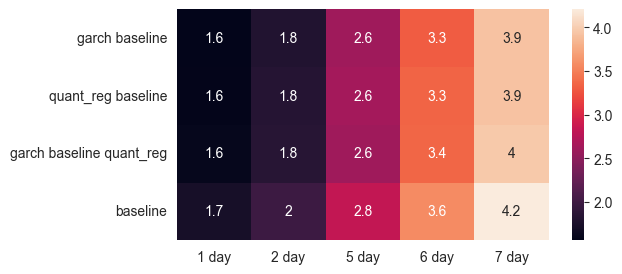

                             1 day     2 day     5 day     6 day     7 day
garch baseline            1.561060  1.792955  2.611281  3.307856  3.924936
quant_reg baseline        1.573522  1.825808  2.646452  3.345027  3.924169
garch baseline quant_reg  1.594958  1.840147  2.615166  3.353185  3.968028
baseline                  1.726224  1.981822  2.831011  3.576804  4.207527
*** Stds of Scores ***


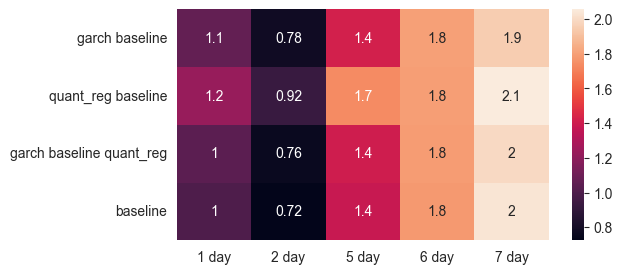

                             1 day     2 day     5 day     6 day     7 day
garch baseline            1.067176  0.777678  1.418398  1.798165  1.949616
quant_reg baseline        1.228505  0.924095  1.738180  1.791342  2.056528
garch baseline quant_reg  1.037980  0.760588  1.405887  1.787930  1.990822
baseline                  0.995858  0.724538  1.375364  1.780410  2.033507


In [161]:
def print_means_stds(score_df, models_display):
    means = pd.DataFrame(columns=[str(i) + " day" for i in (1, 2, 5, 6, 7)])
    stds = pd.DataFrame(columns=[str(i) + " day" for i in (1, 2, 5, 6, 7)])
    for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
        m = score_df.loc[:,[f'{m}: {h}' for m in models_display]].mean()
        m.index = [m['name'] for m in models]
        means.loc[:,h] = m
        s = score_df.loc[:,[f'{m}: {h}' for m in models_display]].std()
        s.index = [m['name'] for m in models]
        stds.loc[:,h] = s
    print('*** Mean Score ***')
    plt.figure(figsize=(6, 3))
    means = means.astype(float)
    stds = stds.astype(float)
    sns.heatmap(means, annot=True)
    plt.show()
    print(means)
    
    
    print('*** Stds of Scores ***')
    plt.figure(figsize=(6, 3))
    sns.heatmap(stds, annot=True)
    plt.show()
    print(stds)
    
    
print_means_stds(score_df, [m['name'] for m in models])

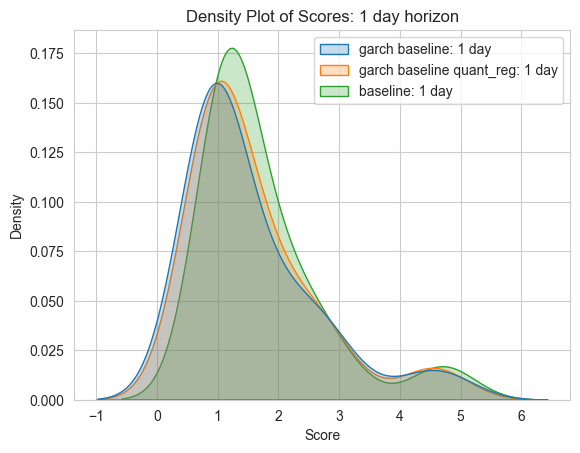

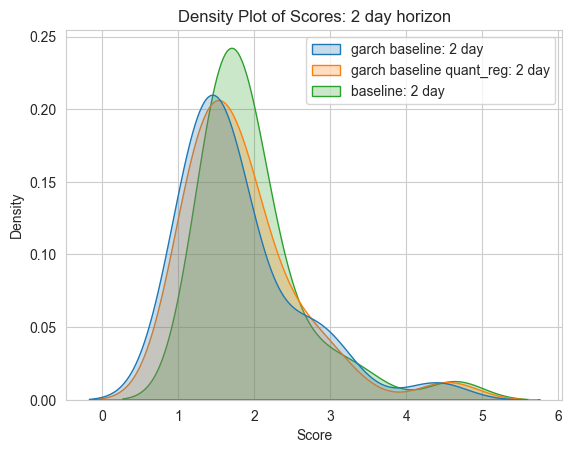

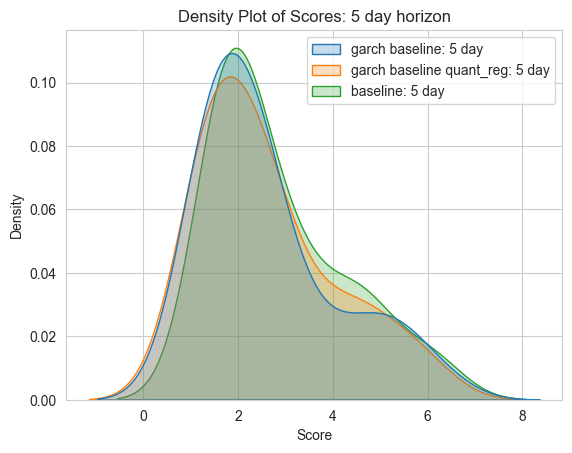

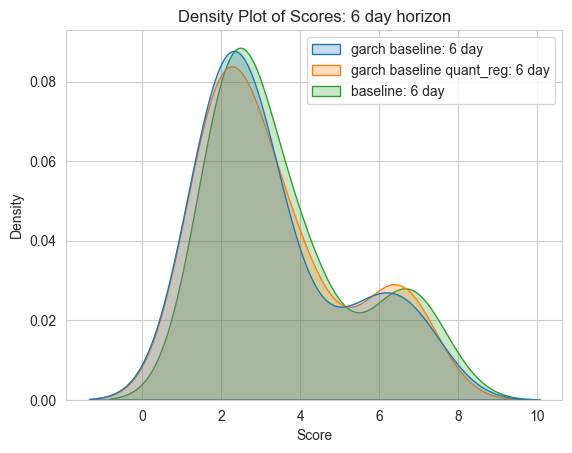

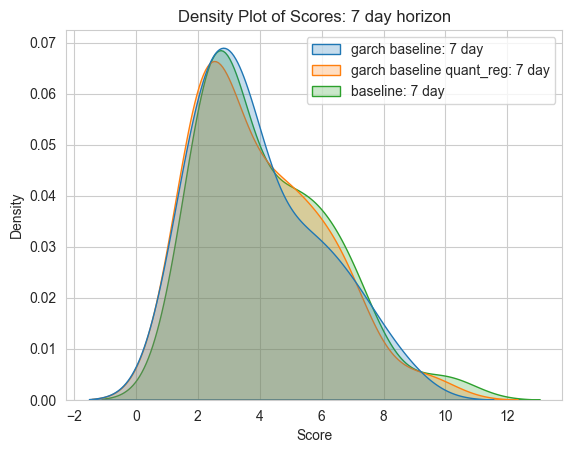

In [153]:
models_display = [m['name'] for m in models]
for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    sns.kdeplot(data=score_df.loc[:,[f'{m}: {h}' for m in models_display]], fill=True)
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {h} horizon')

    # Display the plot
    plt.savefig(f'../Plots/density_plot_{h.replace(" ", "_")}.png')
    plt.show()

In [71]:
import statistics
horizon = '1 day'
score_df.loc[:,[f'{m}: {h}' for m in models_display]]
for i,m in enumerate([statistics.mean(score_df.loc[:,f'{m}: {horizon}'].dropna()) for m in models_display]):
    print(f'{models_display[i]} mean score in the past 50 weeks: {m}')

quant_reg mean score in the past 50 weeks: 1.5275565210882445
baseline mean score in the past 50 weeks: 1.7262239319166002


In [ ]:
for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    score_df_36_no_na = score_df[score_df[f'{models_display[0]}: {h}'].notna()]
    for c in [f'{m}: {h}' for m in models_display]:
        plt.plot(score_df_36_no_na.index, score_df_36_no_na[c], label=c)

    plt.xlabel('time')
    plt.ylabel('score')
    plt.title(f'Comparison of scores over time: {h}')
    # plt.ylim(0,50)
    
    # Display legend
    plt.legend()
    plt.xticks(rotation=45)
    plt.savefig(f'../Plots/line_plot_{h.replace(" ", "_")}.png')

    # Show the plot
    plt.show()

In [ ]:


import matplotlib.pyplot as plt

def plot_evaluation(evaluation_data):
    # Assuming your DataFrame is named df
    numeric_columns = evaluation_data.select_dtypes(include='number')
    
    # Plotting
    plt.figure(figsize=(12, 8))
    for column in numeric_columns.columns:
        plt.plot(evaluation_data.index, evaluation_data[column], label=column)
    plt.plot(evaluation_data.index, evaluation_data['observation'], label = 'observation')
    
    # Adding labels and legend
    plt.xlabel('Forecast Date')
    plt.ylabel('Values')
    plt.title('Visualization of forecast and observation')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig(f'../plots/evaluation_overview.png')
    plt.show()



In [ ]:
model_index = 1
plot_evaluation(models[model_index]['evaluation'][models[model_index]['evaluation']['horizon'] == '5 day'].dropna())

In [ ]:
models[0]['evaluation']